# **Finding Lane Lines on the Road** 

**The tools used here are: color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection. We put together as a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image/video stream for display. An example is shown below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Raw Sample Output </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Required Sample Output </p> 
 </figcaption>
</figure>

In [1]:
#JGJ JSR

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pandas as pd
import numpy as np
import imageio
import cv2
import os
%matplotlib inline

In [3]:
#reads and returns image 
def read_img(image_path):
    img = cv2.imread(image_path)
    return img

#prints image type and dimensions and returns image
def img_stats(image): 
    print("The image is of type: "+str(type(image))+" and has dimensions:"+str(image.shape)) #returns (y,x,RGB)
    return image

**Some useful OpenCV functions that may come in handy:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

### Some helper functions:

In [4]:
import math

"""Applies the Grayscale transform
This will return an image with only one color channel
but NOTE: to see the returned image as grayscale
you should call plt.imshow(gray, cmap='gray')"""
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
"""Applies a Gaussian Blur kernel"""
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
"""Applies the Canny transform"""
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

"""
Applies an image mask.
Only keeps the region of the image defined by the polygon
formed from `vertices`. The rest of the image is set to black.
"""
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


"""
`img` should be the output of a Canny transform.     
Returns an image with hough lines drawn.
"""
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.copy(img)*0
    print(line_img)
    extrapolated_lines = extrapolator(img.shape,lines.squeeze())
    line_img = np.zeros(img.shape, dtype=np.uint8)
    print("THIS IS EXTRAPOLATED:")
    print(extrapolated_lines)
    imgr = draw_lines(line_img, extrapolated_lines,color=[255, 0, 0], thickness=5)
    plt.imshow(imgr)
    plt.show()
    return imgr


"""
NOTE: this is the function you might want to use as a starting point once you want to 
average/extrapolate the line segments you detect to map out the full
extent of the lane (going from the result shown in raw-lines-example.mp4
to that shown in P1_example.mp4).  
    
Think about things like separating line segments by their 
slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
line vs. the right line.  Then, you can average the position of each of 
the lines and extrapolate to the top and bottom of the lane.
    
This function draws `lines` with `color` and `thickness`.    
Lines are drawn on the image inplace (mutates the image).
If you want to make the lines semi-transparent, think about combining
this function with the weighted_img() function below
"""
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    if len(img.shape) == 2:  # grayscale image -> make a "color" image out of it
        img = np.dstack((img, img, img))
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            print(x1,y1,x2,y2)
            if x1 >= 0 and x1 < img.shape[1] and \
                y1 >= 0 and y1 < img.shape[0] and \
                x2 >= 0 and x2 < img.shape[1] and \
                y2 >= 0 and y2 < img.shape[0]:
                #print("HERE")
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                plt.imshow(img)
                plt.show()
            else:
                print('BAD LINE (%d, %d, %d, %d)' % (x1, y1, x2, y2))
    return img
                
"""
`img` is the output of the hough_lines(), An image with lines drawn on it.
Should be a blank image (all black) with lines drawn on it.
`initial_img` should be the image before any processing.
The result image is computed as follows:
initial_img * α + img * β + λ
NOTE: initial_img and img must be the same shape!
"""
def weighted_img(img, initial_img, alpha=0.8, beta=1., lamda=0.):
    return cv2.addWeighted(initial_img, alpha, img, beta, lamda)

### Custom helper functions:

In [5]:
# Calculates slope for pairs of points [[x1,y1,x2,y2],[x3,y3,x4,y4]....] that hough_lines returns 
# hough_lines performs Hough transformation and returns lines in Hough space and points in Cartesian space
# get_coords returns the slope and intercept of the lane lines
def get_coords(imshape,line_pair):
    x1 = line_pair[0]
    y1 = line_pair[1]
    x2 = line_pair[2]
    y2 = line_pair[3]
    m = (y1-y2)/(x1-x2)
    b = y1 - m*x1 #or y2 - m*x2
    return (m,b)

def extrapolator(imshape,lines):
    slope_min = 0.5
    slope_max = 2.0
    mL=np.array([])
    mR=np.array([])
    bL=np.array([])
    bR=np.array([])
    for line_pair in lines:
        (m,b) = get_coords(imshape,line_pair)
        if abs(m) > slope_min and abs(m) < slope_max: 
            #Separate into left & right lanes using the sign of the slope
            if (m > 0):
                mL = np.append(mL, m)
                bL = np.append(bL, b)
            else:
                mR = np.append(mR, m)
                bR = np.append(bR, b)
    
    #Average the L & R lines
    print(mL)
    print(mR)
    print(bR)
    print(bL)
    mL = np.mean(mL)
    bL = np.mean(bL)
    mR = np.mean(mR)
    bR = np.mean(bR)
    print(mL)
    print(mR)
    print(bR)
    print(bL)
    
    #END POINT FOR LANES
    #Compute the L & R lines intersection point in the image
    x_cross = (bR - bL) / (mL - mR)
    y_cross = mR * x_cross + bR #or mL * x_cross + bL
    print("THE CROSSING POINT:")
    print(x_cross,y_cross)
    
    #START POINT FOR LANES
    #Compute the x-coordinate where the lanes emerge/start (at the bottom of the image)
    yL_start = imshape[0]-1
    xL_start = (imshape[0]-bL)/mL
    yR_start = imshape[0]-1
    xR_start = (imshape[0]-bR)/mR
    print("THE STARTING POINT:")
    print(xL_start,yL_start,xR_start,yR_start)
    
    print(np.array([[[min(xL_start,xR_start), yL_start, x_cross, y_cross]], [[max(xL_start,xR_start), yR_start, x_cross, y_cross]]]))
    return np.array([[[min(xL_start,xR_start), yL_start, x_cross, y_cross]], [[max(xL_start,xR_start), yR_start, x_cross, y_cross]]]).astype(int)

## Pipeline implementation

Here, we take the original image as input and then return its annotated version i.e. with detected lines drawn on it.

### Steps:
1 Read image and print its statistics <br /> 
2 Convert image to grayscale <br /> 
3 Apply Gaussian smoothing/blurring to reduce image noise and reduce detail (specify kernel size) <br /> 
4 Apply Canny transform to get edge detected image (specify low & high threshold) <br /> 
5 (a) Apply image mask to only keep the region of interest in the image that is defined using polygon (specify vertices) <br /> 
5 (b) Masking sets everything outside the region of interest i.e. the rest of the image to black <br /> 
6 Apply Hough transform on masked edge-detected image for extraction of the above feature (specify transformation params) <br /> 
7 Extrapolate edges/lane line segments obtained above to map out the full extent of the lane (specify left & right lines) <br /> 
8 Combine this image with the original image to see how accurate the line annotations are <br /> 

In [6]:
# Sets the functions' parameters
def set_params(image):
    imshape = image.shape
    vrtx = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    param_dict = {'kernel_size':5,'low_threshold':50,'high_threshold':200,'vertices':vrtx,'rho':2,'theta':np.pi/180,'threshold':45,'min_line_len':40,'max_line_len':100}
    values = []
    values.append(param_dict)
    parameters = pd.DataFrame(values)    
    return parameters

# Master code
def pipeline(image_path):
    if (isinstance(image_path, str)):
        image_path = read_img(image_path)
        plt.imshow(image_path)
        plt.show()
        
    params = set_params(image_path)
    img2 = img_stats(image_path)
    img3 = grayscale(img2)
    img4 = gaussian_blur(img3,params.iloc[0]['kernel_size'])
    img5 = canny(img4,params.iloc[0]['low_threshold'],params.iloc[0]['high_threshold'])
    plt.imshow(img5)
    plt.show()
    img6 = region_of_interest(img5,params.iloc[0]['vertices'])
    plt.imshow(img6)
    plt.show()
    img7 = hough_lines(img6,params.iloc[0]['rho'],params.iloc[0]['theta'],params.iloc[0]['threshold'],params.iloc[0]['min_line_len'],params.iloc[0]['max_line_len'])
    print(img7.shape)
    print(image_path.shape)
    final_img = weighted_img(img7,image_path)
    plt.imshow(final_img)
    plt.show()
    print("We're done!")
    return final_img

def overlay_lanemarkings(img, lanemarkings):
    """ Draws the lines on top of the image img """
    # Create a black image with red lanemarkings
    img_lines = np.copy(img)*0
    draw_lines(img_lines, lanemarkings, color=[255, 0, 0], thickness=20)
    
    # Blend the original image with the previous one
    img_out = weighted_img(img_lines, img)
    return img_out

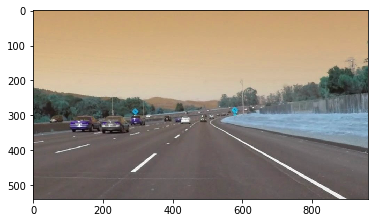

The image is of type: <class 'numpy.ndarray'> and has dimensions:(540, 960, 3)


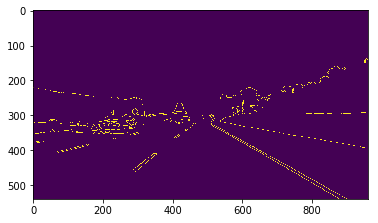

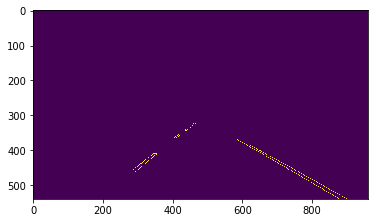

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[ 0.55263158  0.57679181]
[-0.72727273 -0.8373494  -0.72988506 -0.80473373 -0.75438596]
[ 663.63636364  708.01807229  663.5862069   695.56804734  669.66666667]
[ 41.73684211  32.15358362]
0.564711693911
-0.770725375011
680.095071365
36.9452128615
THE CROSSING POINT:
481.602520606 308.911788065
THE STARTING POINT:
890.817017893 539 181.770415128 539
[[[ 181.77041513  539.          481.60252061  308.91178806]]

 [[ 890.81701789  539.          481.60252061  308.91178806]]]
THIS IS EXTRAPOLATED:
[[[181 539 481 308]]

 [[890 539 481 308]]]
181 539 481 308


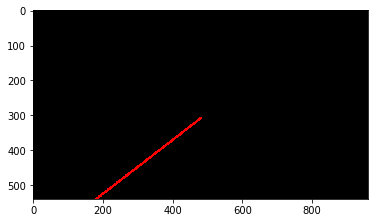

890 539 481 308


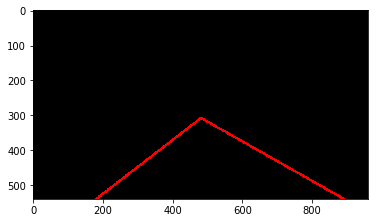

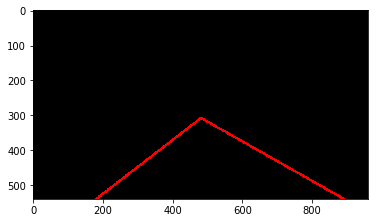

(540, 960, 3)
(540, 960, 3)


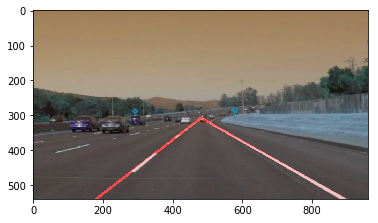

We're done!


array([[[159, 126,  87],
        [159, 126,  87],
        [159, 126,  87],
        ..., 
        [158, 125,  89],
        [155, 122,  86],
        [151, 118,  82]],

       [[159, 126,  87],
        [159, 126,  87],
        [159, 126,  87],
        ..., 
        [158, 125,  89],
        [155, 122,  86],
        [152, 119,  83]],

       [[159, 126,  87],
        [159, 126,  87],
        [159, 126,  87],
        ..., 
        [158, 125,  89],
        [155, 122,  86],
        [152, 119,  83]],

       ..., 
       [[ 76,  70,  68],
        [ 76,  70,  68],
        [ 76,  70,  68],
        ..., 
        [ 73,  65,  65],
        [ 72,  64,  64],
        [ 71,  63,  63]],

       [[ 75,  69,  69],
        [ 75,  69,  69],
        [ 76,  70,  70],
        ..., 
        [ 71,  64,  62],
        [ 71,  64,  62],
        [ 70,  63,  61]],

       [[ 74,  67,  67],
        [ 74,  67,  67],
        [ 74,  67,  67],
        ..., 
        [ 72,  62,  61],
        [ 71,  62,  60],
        [ 70,  61,

In [7]:
pipeline('./CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidWhiteCurve.jpg')

In [8]:
def process_image(image):
    """Puts image through pipeline and returns 3-channel image for processing video below."""
    result = pipeline(image)
    print(result.shape)
    return result

In [9]:
white_output = 'challengeRoad.mp4'
vid = r".\CarND-LaneLines-P1-master\CarND-LaneLines-P1-master\test_videos\solidWhiteRight.mp4"

The image is of type: <class 'numpy.ndarray'> and has dimensions:(720, 1280, 3)


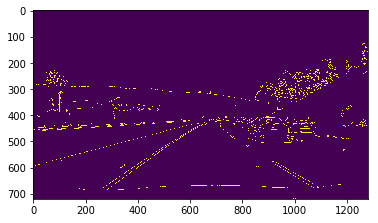

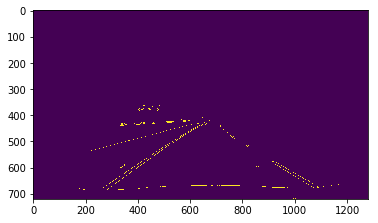

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[ 0.5739645   0.6492891   0.6234414   0.67489712  0.64736842]
[-0.67181467 -0.72492837 -0.67410714 -0.65027322 -0.6730038  -0.67272727
 -0.62371134 -0.67613636]
[ 855.96911197  887.97994269  867.16964286  853.92896175  857.28897338
  863.58181818  833.16494845  866.10795455]
[ 47.08284024 -14.492891     9.29426434 -36.23045267 -16.44736842]
0.633792106694
-0.670837773041
860.648919229
-2.15872150307
THE CROSSING POINT:
661.34284837 416.995155612
THE STARTING POINT:
1139.4252372 719 209.661597604 719
[[[  209.6615976    719.           661.34284837   416.99515561]]

 [[ 1139.4252372    719.           661.34284837   416.99515561]]]
THIS IS EXTRAPOLATED:
[[[ 209  719  661  416]]

 [[1139  719  661  416]]]
209 719 661 416


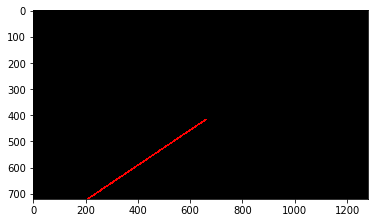

1139 719 661 416


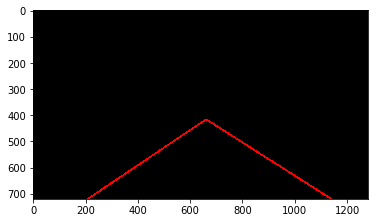

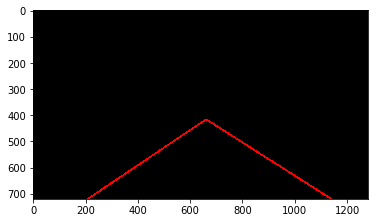

(720, 1280, 3)
(720, 1280, 3)


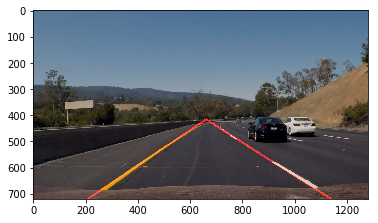

We're done!
(720, 1280, 3)


In [11]:
clip1 = VideoFileClip("challenge.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!